In [1]:
%load_ext autoreload

# 引入必要的库

In [2]:
%autoreload
import sys,os
import numpy as np
import matplotlib.pyplot as plt
from tianmoucv.isp import fourdirection2xy,poisson_blend
import torch
from tianmoucv.data import TianmoucDataReader
import torch.nn.functional as F
import cv2

train='/data/tianmoucData/tianmoucReconDataset_merged/train/'
dirlist = os.listdir(train)
traindata = [train + e for e in dirlist]

val='/data/tianmoucData/tianmoucReconDataset_merged/test/'
vallist = os.listdir(val)
valdata = [val + e for e in vallist]
key_list = []

print('---------------------------------------------------')
for sampleset in traindata:
    print('---->',sampleset,'有：',len(os.listdir(sampleset)),'个样本')
    for e in os.listdir(sampleset):
        print(e)
        key_list.append(e)
print('---------------------------------------------------')
for sampleset in valdata:
    print('---->',sampleset,'有：',len(os.listdir(sampleset)),'个样本')
    for e in os.listdir(sampleset):
        print(e)
        key_list.append(e)
        
all_data = valdata + traindata


import TianmouCV 0.1, via Y. Lin, T. Wang  pre release version
---------------------------------------------------
----> /data/tianmoucData/tianmoucReconDataset_merged/train/normal 有： 57 个样本
train_indoor_dog2
train_running_man_1
train_running_man_3
outdoor_4huan
outdoor_cross_11
outdoor_cross_12
train_driving10
outdoor_bridge_2
train_indoor_dog4
train_cross1
train_exam_full1
train_indoor_dog1
train_driving3
train_running_man_7
outdoor_hutong_1
train_driving9
train_exam_fan3
train_cross3
train_driving1
outdoor_cross_7
outdoor_cross_1
train_driving14
train_cross2
outdoor_cross_4
train_exam_fan5
indoor_slefie_1
train_running_man_5
train_cross4
train_man_play_ball1
outdoor_cross_5
train_driving8
train_driving2
train_exam_full2
train_driving13
train_driving4
outdoor_cross_8
indoor_office_2
indoor_keyboard1
train_running_man_6
train_driving11
indoor_office_4
indoor_slefie_2
train_exam_fan2
indoor_office_3
train_driving5
train_running_man_2
train_driving6
outdoor_cross_3
outdoor_bridge_1
outd

In [3]:
key_list = ['underbridge_hdr_4']

# 融合图像

['/data/tianmoucData/tianmoucReconDataset_merged/train/extreme/underbridge_hdr_4/rod/tianmouc_raw_data_373476794.tmdat']
['/data/tianmoucData/tianmoucReconDataset_merged/train/extreme/underbridge_hdr_4/cone/tianmouc_raw_data_373473658.tmdat']
labelFileName: /data/tianmoucData/tianmoucReconDataset_merged/train/extreme/underbridge_hdr_4/label.csv doesnot have status label
underbridge_hdr_4@/data/tianmoucData/tianmoucReconDataset_merged/train/extreme origin length: 151
underbridge_hdr_4@/data/tianmoucData/tianmoucReconDataset_merged/train/extreme ---legal sample num: 151


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cost: 0.07191777229309082 s


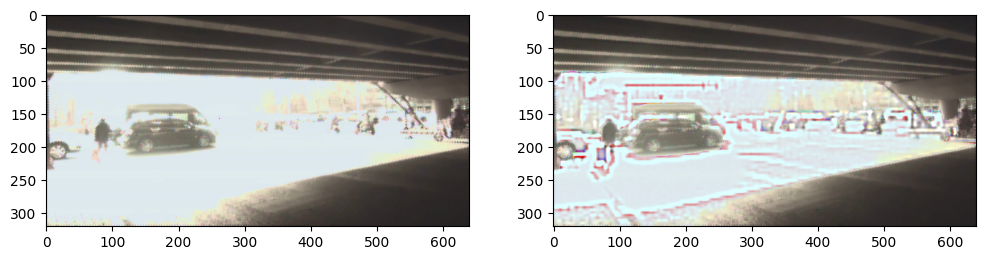

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cost: 0.04439663887023926 s


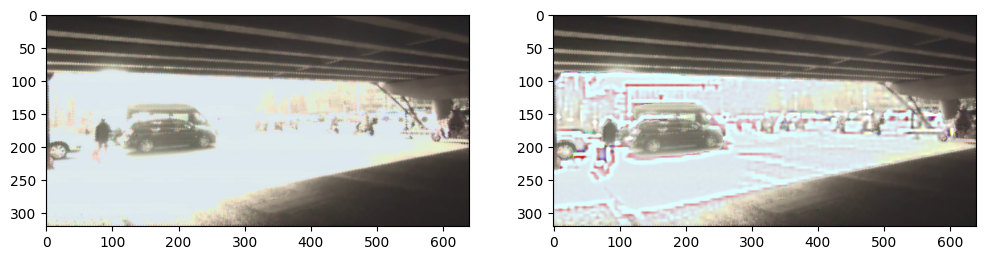

In [4]:
%autoreload
import torch.nn as nn
import math
import time

MSE_LossFn = nn.MSELoss()
speedUpRate = 1

def images_to_video(frame_list,name,size=(640,320),Flip=False):
    fps = 25        
    ftmax = max([np.max(ft) for ft in frame_list])
    ftmin = min([np.min(ft) for ft in frame_list])
    out = cv2.VideoWriter(name,0x7634706d , fps, size)
    for ft in frame_list:
        ft = (ft-ftmin)/(ftmax-ftmin)
        ft2 = (ft*255).astype(np.uint8)
        out.write(ft2)
    out.release()

psnrcount =0
count = 0

from tianmoucv.isp import laplacian_blending


for key in key_list:
    dataset = TianmoucDataReader(all_data,MAXLEN=500*speedUpRate,ifSaveFileDict = False,matchkey=key,speedUpRate=speedUpRate)
    dataLoader = torch.utils.data.DataLoader(dataset, batch_size=1,\
                                          num_workers=4, pin_memory=False, drop_last = False)

    PSNR = 0
    img_list = []
    for index,sample in enumerate(dataLoader,0):
        if index<0:
            continue
        if index<= 1:
            psnrcount += 1
            F0 = sample['F0'][0,...]
            F0_HDR = sample['F0_HDR'][0,...]

            raw_F0 = F0.clone()

            
            for t in [0]:
                tsdiff = sample['rawDiff'][0,...]/128.0        
                SD = tsdiff[1:,t,...].permute(1,2,0)
                ts= time.time()
                Ix,Iy= fourdirection2xy(SD)
                Ix = F.interpolate(torch.Tensor(Ix).unsqueeze(0).unsqueeze(0), size=(320,640), mode='bilinear').squeeze(0).squeeze(0)
                Iy = F.interpolate(torch.Tensor(Iy).unsqueeze(0).unsqueeze(0), size=(320,640), mode='bilinear').squeeze(0).squeeze(0)
                blend_hdr = laplacian_blending(-Ix,-Iy, srcimg= F0,iteration=15, mask_rgb=True,mask_th=24)
                te = time.time()
                print('cost:',te-ts,'s')
                
                show = torch.cat([raw_F0,blend_hdr],dim=0)
            
                img_list.append(show.numpy()[...,[2,1,0]])
            

            plt.figure(figsize=(12,6))
            plt.subplot(1,2,1)  
            plt.imshow(F0)
            plt.subplot(1,2,2)  
            plt.imshow(blend_hdr)
            plt.show()
        else:
            break
    
    #images_to_video(img_list,size=(640,640),name='./Direct_'+key+'.mp4')